<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/LSTMSerieTemporalESP32/blob/main/TemperaturaPressaoUmidadeLSTMSerieTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SérieTemporal LSTM de Temperatura,Pressão e Umidade para Microcontrolador 

In [1]:
# Importing bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
### dados do Max plank Instituto de pesquisa 

zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip' , fname='jena_climate_2009_2016.csv.zip', extract=True)
print(zip_path)

csv_path = os.path.splitext(zip_path)

print(csv_path)

13582336/13568290 [==============================] - 0s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
('/root/.keras/datasets/jena_climate_2009_2016.csv', '.zip')


In [3]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [4]:
### criando dataset csv
import zipfile

zf = zipfile.ZipFile(zip_path)
df = pd.read_csv(zf.open('jena_climate_2009_2016.csv'))

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
## features 

features_3 = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_3]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84cb23e7d0>,
      dtype=object)

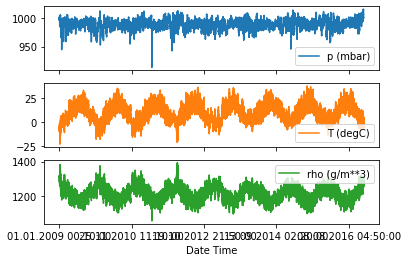

In [7]:
features.plot(subplots=True)

In [15]:
## divisão de teste  para média de janela móvel de série temporal simples
train_split = 300000
tf.random.set_seed(13)

In [10]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [11]:
### criar mutlivariate dataset

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [26]:
### função para criar passos de tempo
def create_time_steps(length):
  return list(range(-length,0))

### função para plotar dados de séries temporais

def plot_time_series(plot_data, delta , title):
  labels = ["Histórico" , 'Valor Futuro Verdadeiro' , 'Valor Predito Pelo Modelo']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt



In [12]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(299280, 120, 3) (299280,)


In [18]:
## tensorflow dataset
batch_size = 256
buffer_size = 10000
train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [21]:
## treinamento da modelo LSTM
steps = 200
EPOCHS =10
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 24s 107ms/step - loss: 0.4228 - val_loss: 0.2662
Epoch 2/10
200/200 [==============================] - 26s 129ms/step - loss: 0.2678 - val_loss: 0.2482
Epoch 3/10
200/200 [==============================] - 23s 113ms/step - loss: 0.2627 - val_loss: 0.2802
Epoch 4/10
200/200 [==============================] - 29s 143ms/step - loss: 0.2626 - val_loss: 0.2450
Epoch 5/10
200/200 [==============================] - 24s 120ms/step - loss: 0.2287 - val_loss: 0.2439
Epoch 6/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2453 - val_loss: 0.2696
Epoch 7/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2459 - val_loss: 0.2697
Epoch 8/10
200/200 [==============================] - 28s 140ms/step - loss: 0.2453 - val_loss: 0.2662
Epoch 9/10
200/200 [==============================] - 26s 132ms/step - loss: 0.2500 - val_loss: 0.2516
Epoch 10/10
200/200 [==============================] - 23s 115ms/step - l

In [30]:
## plota train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()
  
  plot_loss(single_step_model_history , 'Single Step Training and validation loss')

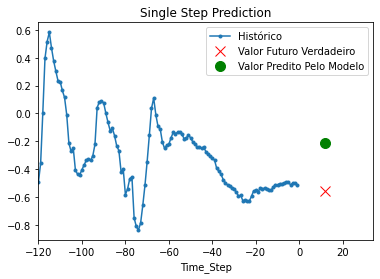

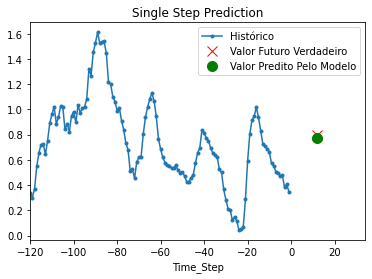

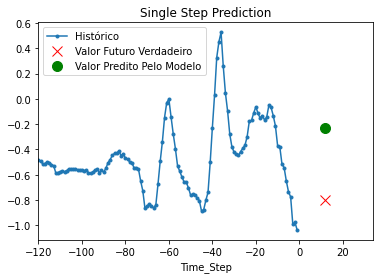

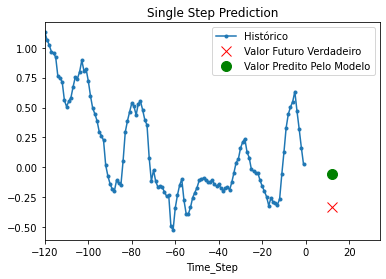

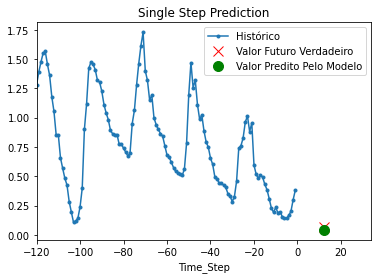

In [27]:
# plotar séries temporais e valores previstos

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [28]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(299280, 120, 3)
(299280, 72)


In [31]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

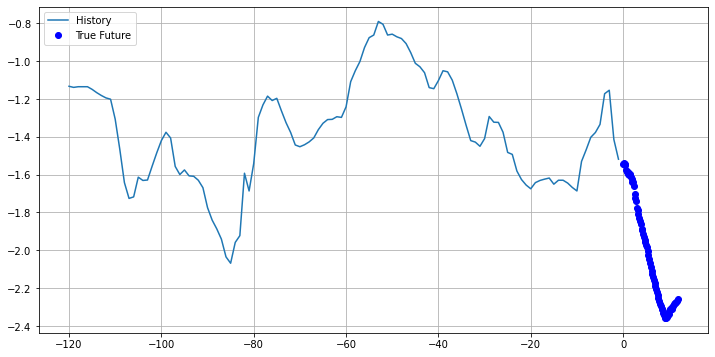

In [32]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [33]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 40s 184ms/step - loss: 0.6767 - val_loss: 0.3069
Epoch 2/10
200/200 [==============================] - 37s 183ms/step - loss: 0.3465 - val_loss: 0.2858
Epoch 3/10
200/200 [==============================] - 37s 186ms/step - loss: 0.3056 - val_loss: 0.2353
Epoch 4/10
200/200 [==============================] - 39s 197ms/step - loss: 0.2430 - val_loss: 0.2136
Epoch 5/10
200/200 [==============================] - 37s 183ms/step - loss: 0.2025 - val_loss: 0.1986
Epoch 6/10
200/200 [==============================] - 36s 182ms/step - loss: 0.2107 - val_loss: 0.2141
Epoch 7/10
200/200 [==============================] - 37s 183ms/step - loss: 0.2027 - val_loss: 0.2066
Epoch 8/10
200/200 [==============================] - 36s 182ms/step - loss: 0.1978 - val_loss: 0.1996
Epoch 9/10
200/200 [==============================] - 36s 181ms/step - loss: 0.2001 - val_loss: 0.1986
Epoch 10/10
200/200 [==============================] - 36s 182ms/step - l

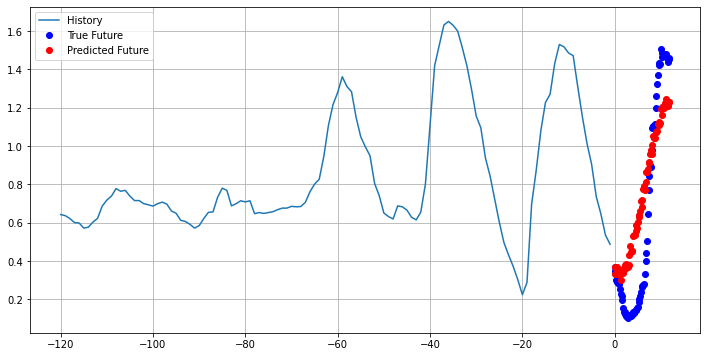

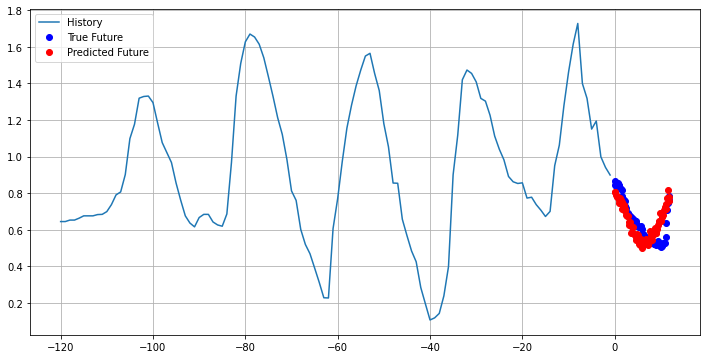

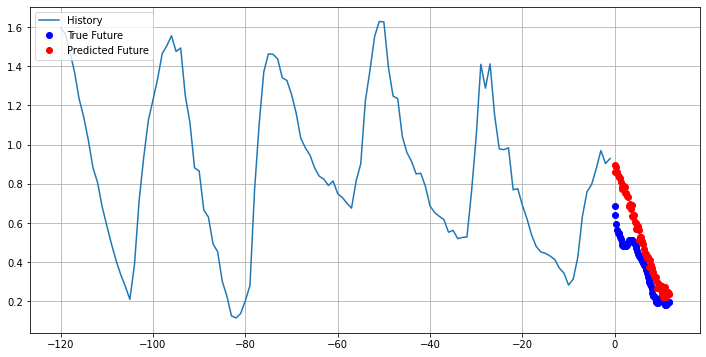

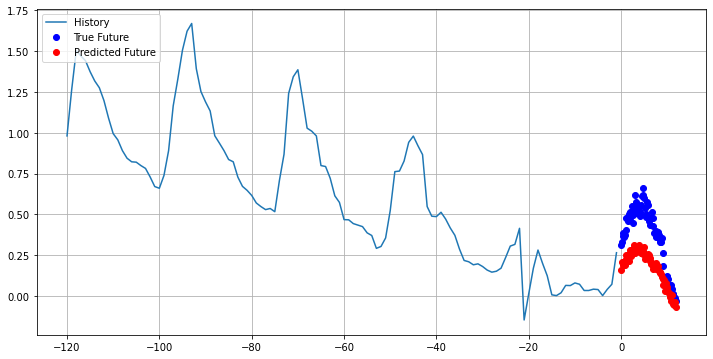

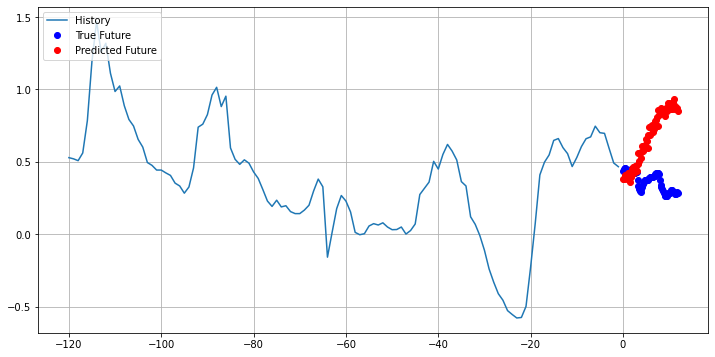

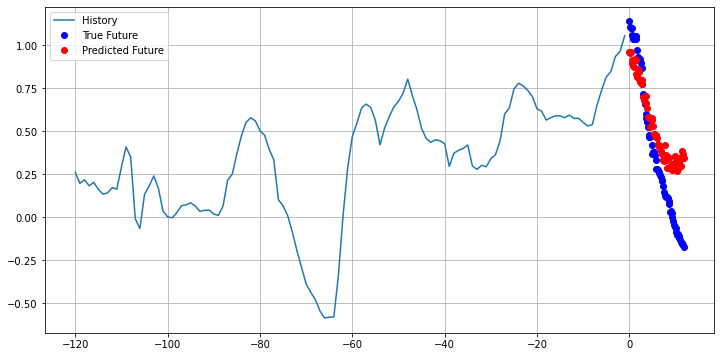

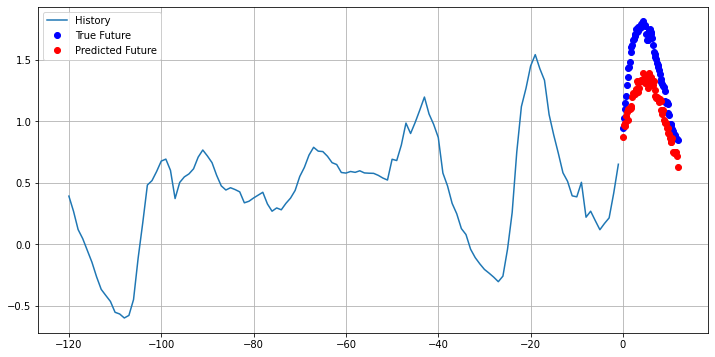

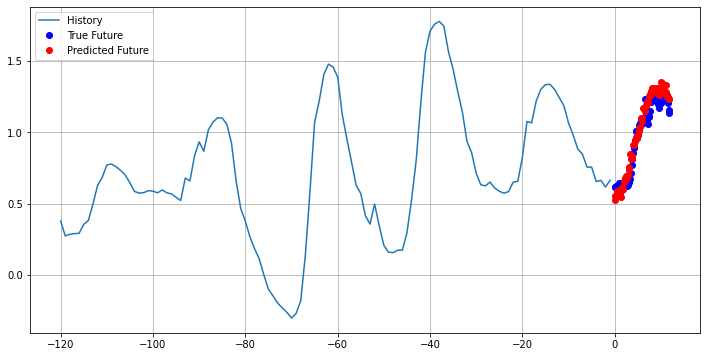

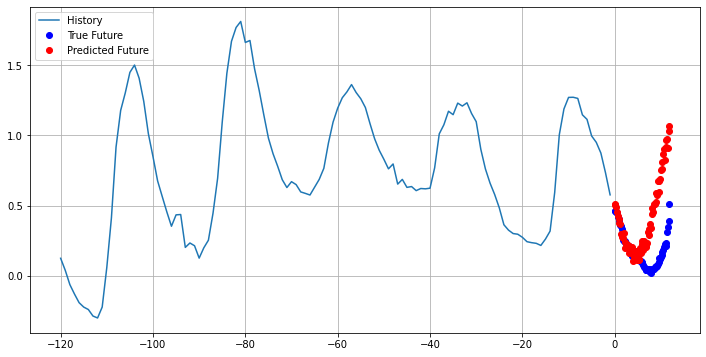

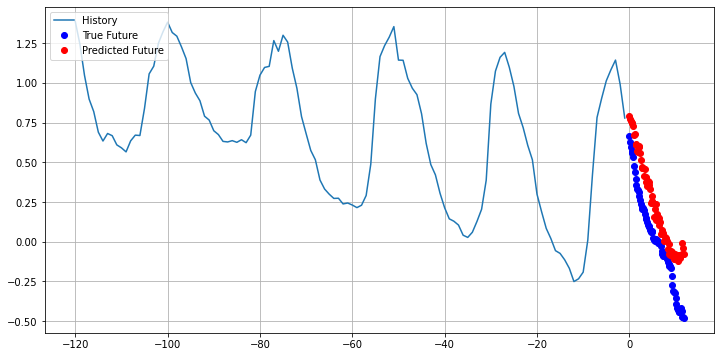

In [35]:
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Modelo Keras

In [37]:
multi_step_model.save('modelkeras.h5') 

In [39]:
MODEL_TFLITE = '/content/modelkeras.h5'
MODEL_TFLITE_MICRO = '/content/binarioh5.cc'

In [40]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [41]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

A saída de streaming foi truncada nas últimas 5000 linhas.
  0xbc, 0xa8, 0x75, 0xbe, 0x5a, 0x7c, 0x44, 0x3e, 0xf3, 0x2c, 0xb4, 0xbd,
  0x86, 0x3e, 0x4d, 0xbe, 0x42, 0xea, 0x41, 0x3d, 0x06, 0x03, 0x55, 0x3e,
  0x71, 0x62, 0xeb, 0xbd, 0x2a, 0x6c, 0x11, 0x3e, 0x85, 0x0b, 0xc1, 0xbd,
  0xf3, 0xe5, 0x04, 0xbe, 0x60, 0x15, 0xe8, 0x3d, 0x3d, 0x4b, 0xbe, 0x3d,
  0x6b, 0x02, 0x5a, 0x3d, 0x36, 0xc9, 0xb5, 0xbd, 0xc1, 0x86, 0x1c, 0x3e,
  0x01, 0x8a, 0x3f, 0x3e, 0x77, 0x9f, 0x53, 0x3e, 0x63, 0x05, 0x5a, 0x3d,
  0x43, 0xc4, 0xdc, 0xbe, 0x7e, 0x09, 0x65, 0xbe, 0xa0, 0xf5, 0xa7, 0xbd,
  0x24, 0x69, 0x3b, 0xbd, 0xda, 0x48, 0xac, 0xbc, 0x79, 0xc6, 0xa8, 0x3e,
  0x58, 0x2d, 0x77, 0xbe, 0xde, 0xae, 0x62, 0x3d, 0x2f, 0x49, 0x95, 0xbe,
  0xc0, 0xa0, 0x30, 0x3e, 0x19, 0x0d, 0x78, 0xbe, 0x10, 0x6c, 0xc1, 0xbb,
  0x0e, 0xb8, 0x87, 0xbd, 0x8d, 0x72, 0xb3, 0x3e, 0x73, 0xe1, 0x88, 0xbd,
  0x91, 0xa3, 0x51, 0x3c, 0x85, 0xee, 0xe1, 0xbe, 0x70, 0xce, 0x9b, 0xbd,
  0xc0, 0x77, 0x05, 0xbe, 0xb8, 0x41, 0x99, 0x3d, 0x1

#Modelo Tensorflow Lite

In [46]:
#converter para TensorflowLite
converter = tf.lite.TFLiteConverter.from_keras_model(multi_step_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('modeltflite.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpnwl2b8ap/assets


INFO:tensorflow:Assets written to: /tmp/tmpnwl2b8ap/assets


In [47]:
MODEL_TFLITE = '/content/modeltflite.tflite'
MODEL_TFLITE_MICRO = '/content/binariotflite.cc'

In [48]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [49]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x64, 0x00, 0x00, 0x00, 0x64, 0x03, 0x00, 0x00,
  0x74, 0x00, 0x00, 0x00, 0x14, 0x03, 0x00, 0x00, 0x8c, 0x02, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x90, 0xb2, 0x00, 0x00, 0xe4, 0xb1, 0x00, 0x00,
  0x28, 0xb1, 0x00, 0x00, 0x7c, 0xb0, 0x00, 0x00, 0xec, 0xaf, 0x00, 0x00,
  0x00, 0xaf, 0x00, 0x00, 0xd4, 0xad, 0x00, 0x00, 0x68, 0xac, 0x00, 0x00,
  0x0c, 0xab, 0x00, 0x00, 0x50, 0xa1, 0x00, 0x00, 0xf0, 0x9d, 0x00, 0x00,
  0x5c, 0x52, 0x00, 0x00, 0xbc, 0x50, 0x00, 0x00, 0xf8, 0x4d, 0x00, 0x00,
  0x5c, 0x4d, 0x00, 0x00, 0x7c, 0x4c, 0x00, 0x00, 0x8c, 0x4b, 0x00, 0x00,
  0xd4, 0x48, 0x00, 0x00, 0xe0, 0x09, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0x8c, 0x9f, 0x00, 0x00, 0x28, 0x9d, 0x00, 0x00, 0x04, 0x47, 0x00, 0x00,
  0xac, 0x